# Chapter 3 - Computer Vision


### Importing torchvision Libraries


In [1]:
import torch
from torch import nn
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"
print(torch.__version__, torchvision.__version__)

2.2.1+cu121 0.17.1+cu121


## 1.Getting a dataset (FashionMNIST)


In [2]:
train_data = datasets.FashionMNIST(
    root="data", train=True, download=False, transform=ToTensor(), target_transform=None
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=False,
    transform=ToTensor(),
    target_transform=None,
)

In [3]:
len(train_data), len(test_data)

(60000, 10000)

In [4]:
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [5]:
image, label = train_data[0]
print(f"{image.shape}->(color_channels,height,width)")
print(f'{label} = class name index, "{class_names[label]}"')

torch.Size([1, 28, 28])->(color_channels,height,width)
9 = class name index, "Ankle boot"


- color channel is 1 because fashionMNIST images are black and white
- 28,28 is height and width


### Visualize the data


(-0.5, 27.5, 27.5, -0.5)

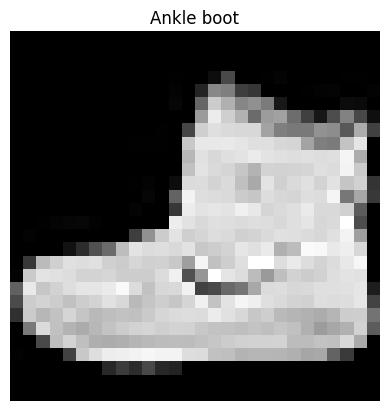

In [6]:
plt.imshow(image.squeeze(), cmap="gray")
plt.title(class_names[label])
plt.axis(False)

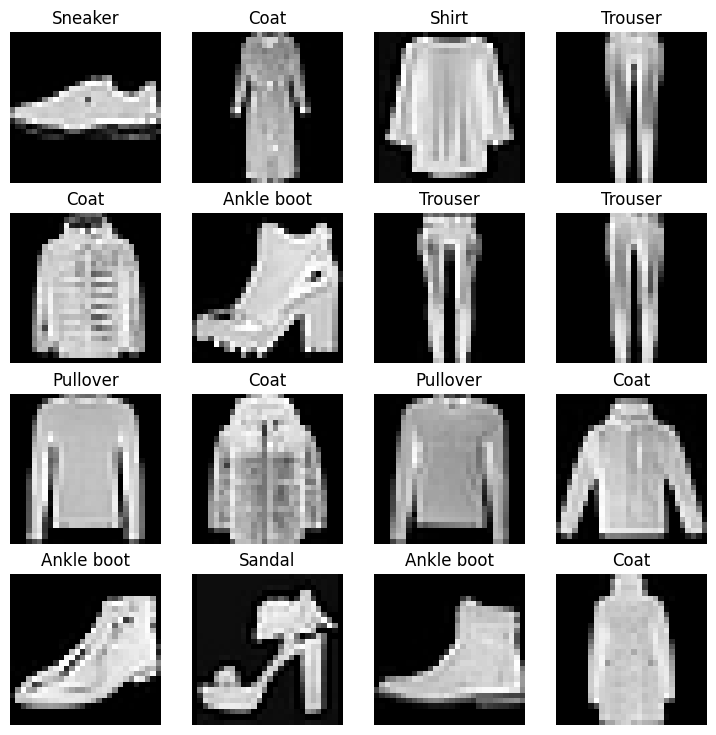

In [7]:
# Plotting more random images
# torch.manual_seed(42)
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows * cols + 1):
    random_i = torch.randint(0, len(train_data), size=[1]).item()
    img, lbl = train_data[random_i]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap="grey")
    plt.title(class_names[lbl])
    plt.axis(False)

## 2.Preparing Dataloader

- Data loader converts data -> Python iterable
- We need to make data -> mini batches
  - use computer memory efficiently
  - memory can't store thousands/millions of data at once
- Mini-batches give NN better change to update gradients per epoch


In [8]:
from torch.utils.data import DataLoader

BATCH = 32
train_dataloader = DataLoader(dataset=train_data, batch_size=BATCH, shuffle=True)
test_dataloader = DataLoader(dataset=test_data, batch_size=BATCH, shuffle=False)

In [9]:
len(train_dataloader), len(test_dataloader)

(1875, 313)

In [10]:
# Whats inside dataloder? (Showing contents of a single batch)
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

Image size: torch.Size([1, 28, 28])
Label:2


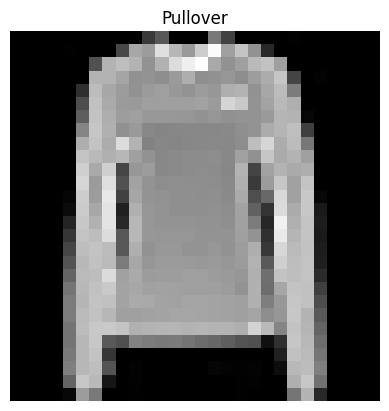

In [11]:
# Selecting a random sample from batch
random_i = torch.randint(low=0, high=len(train_features_batch), size=[1]).item()  # 32
img, label = train_features_batch[random_i], train_labels_batch[random_i]

plt.imshow(img.squeeze(), cmap="grey")
plt.title(class_names[label])
plt.axis(False)
print(f"Image size: {img.shape}")
print(f"Label:{label}")

## 3.Model0: Build a baseline model

- Build simple model first
- Improve it by adding further complexity if it's not doing well


In [12]:
# Creating flatten layer:
flatten = nn.Flatten()

x = train_features_batch[0]  # Single sample
output = flatten(x)

print(f"unflattened: {x.shape}->Color x Height x Width")
print(f"flattened: {output.shape}->Color x Height * Width")

unflattened: torch.Size([1, 28, 28])->Color x Height x Width
flattened: torch.Size([1, 784])->Color x Height * Width


In [13]:
from torch import nn


class FMNISTmodel0(nn.Module):

    def __init__(self, input, hidden, output):
        super().__init__()

        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input, out_features=hidden),
            nn.Linear(in_features=hidden, out_features=output),
        )

    def forward(self, x):

        return self.layer_stack(x)

In [14]:
torch.manual_seed(42)
model0 = FMNISTmodel0(input=784, hidden=10, output=len(class_names)).to(device)
model0

FMNISTmodel0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

### Loss function, Optimizer and Metrics


In [15]:
from helper_functions import accuracy_fn

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model0.parameters(), lr=0.1)

In [16]:
# Timer function
from timeit import default_timer as timer


def print_train_time(start: float, end: float, device):
    time = end - start
    print(f"Training time on {device}: {time:.2f} seconds")
    return time

### Creating training loop and training batches

- Updating model parameters after batches instead of epochs


In [17]:
from tqdm.auto import tqdm


torch.manual_seed(42)
start_time = timer()

epochs = 3
###Epoch loop
for epoch in tqdm(range(epochs)):
    print(f"Epoch {epoch}\n-------------------------------")
    ###Training
    train_loss = 0.0
    # Training Batch loop
    for batch, (X, y) in enumerate(train_dataloader):
        model0.train()
        # 1. Forward pass
        y_preds = model0(X.to(device))
        # 2. Calculate loss
        loss = loss_fn(y_preds, y.to(device))
        train_loss += loss
        # 3.Optimizer zero grad
        optimizer.zero_grad()
        # 4.Backward pass
        loss.backward()
        # 5.Optimizer step
        optimizer.step()
        # Print out what's happening
        if batch % 400 == 0:
            print(f"Looked at {batch*len(X)}/{len(train_dataloader.dataset)} samples")

    # Calculate average loss outside of training loop
    train_loss /= len(train_dataloader)

    ###Testing
    test_loss, test_acc = 0.0, 0.0
    model0.eval()
    with torch.inference_mode():
        # Testing Batch loop
        for X_test, y_test in test_dataloader:
            X_test = X_test.to(device)
            y_test = y_test.to(device)
            test_preds = model0(X_test)
            test_loss += loss_fn(test_preds, y_test)
            test_acc += accuracy_fn(y_true=y_test, y_pred=test_preds.argmax(dim=1))

        # Calculate average loss and accuracy outside of test loop
        test_loss /= len(test_dataloader)
        test_acc /= len(test_dataloader)
        # Print out whats happening
        print(
            f"train_loss:{train_loss:.4f} | test_loss:{test_loss:.4f} | test_acc:{test_acc:.4f}"
        )
        print()

end_time = timer()
total_train_time_model0 = print_train_time(start_time, end_time, device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 0
-------------------------------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples
train_loss:0.5904 | test_loss:0.5095 | test_acc:82.0387

Epoch 1
-------------------------------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples
train_loss:0.4763 | test_loss:0.4799 | test_acc:83.1969

Epoch 2
-------------------------------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples
train_loss:0.4550 | test_loss:0.4766 | test_acc:83.4265

Training time on cuda: 39.92 seconds


In [18]:
torch.manual_seed(42)


def eval_model(
    model: torch.nn.Module,
    data_loader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    accuracy_fn,
    device,
):
    loss, acc = 0, 0

    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)
            preds = model(X)
            loss += loss_fn(preds, y)
            acc += accuracy_fn(y_true=y, y_pred=preds.argmax(dim=1))
        loss /= len(data_loader)
        acc /= len(data_loader)
    return {"model_name": model.__class__.__name__, "loss": loss, "accuracy": acc}

In [19]:
model0_results = eval_model(
    model0, test_dataloader, loss_fn, accuracy_fn, device=device
)

model0_results

{'model_name': 'FMNISTmodel0',
 'loss': tensor(0.4766, device='cuda:0'),
 'accuracy': 83.42651757188499}

## 4. Model 1: Adding to baseline model


### Non-linear model


In [20]:
torch.manual_seed(42)


class FMNISTmodel1(nn.Module):

    def __init__(self, input, hidden, output):

        super().__init__()

        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input, out_features=hidden),
            nn.ReLU(),
            nn.Linear(in_features=hidden, out_features=output),
            nn.ReLU(),
            nn.Linear(in_features=hidden, out_features=output),
        )

    def forward(self, x):

        return self.layer_stack(x)

In [21]:
torch.manual_seed(42)
model1 = FMNISTmodel1(input=28 * 28, hidden=10, output=len(class_names)).to(device)
next(model1.parameters()).device

device(type='cuda', index=0)

### Loss function and optimizer, eval metrics


In [22]:
loss_fn1 = nn.CrossEntropyLoss()
optimizer1 = torch.optim.SGD(model1.parameters(), lr=0.1)

### Functionizing training and testing loops


In [23]:
def train_step(
    model: torch.nn.Module,
    dataloader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    optimizer: torch.optim.Optimizer,
    accuracy_fn,
    device: torch.device = device,
):
    model.train()

    train_loss, train_acc = 0.0, 0.0

    for X, y in dataloader:

        # Put data into target device

        X, y = X.to(device), y.to(device)

        # 1. Forward pass

        preds = model(X)

        # 2. Calculate loss

        loss = loss_fn(preds, y)

        train_loss += loss

        train_acc += accuracy_fn(y_true=y, y_pred=preds.argmax(dim=1))

        # 3.Optimizer zero grad

        optimizer.zero_grad()

        # 4.Backward pass

        loss.backward()

        # 5.Optimizer step

        optimizer.step()

    # Calculate average loss and accuracy outside of training loop

    train_loss /= len(dataloader)

    train_acc /= len(dataloader)

    print(f"train_loss:{train_loss:.4f} | train_acc:{train_acc:.4f}")

In [24]:
# Functionize testing loop similar to train_step
def test_step(
    model: torch.nn.Module,
    dataloader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    accuracy_fn,
    device: torch.device = device,
):
    model.eval()
    test_loss, test_acc = 0.0, 0.0
    with torch.inference_mode():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            preds = model(X)
            test_loss += loss_fn(preds, y)
            test_acc += accuracy_fn(y_true=y, y_pred=preds.argmax(dim=1))
        test_loss /= len(dataloader)
        test_acc /= len(dataloader)
    print(f"test_loss:{test_loss:.4f} | test_acc:{test_acc:.3f}")

In [25]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
start_time = timer()

epochs = 3
###Epoch loop
for epoch in tqdm(range(epochs)):
    print(f"Epoch {epoch}\n-------------------------------")
    ###Training
    train_step(
        model1,
        train_dataloader,
        loss_fn=loss_fn1,
        optimizer=optimizer1,
        accuracy_fn=accuracy_fn,
        device=device,
    )
    ###Testing
    test_step(model1, test_dataloader, loss_fn1, accuracy_fn, device)

end_time = timer()

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 0
-------------------------------
train_loss:0.6677 | train_acc:75.8833
test_loss:0.5009 | test_acc:82.089
Epoch 1
-------------------------------
train_loss:0.4834 | train_acc:82.7717
test_loss:0.4890 | test_acc:82.688
Epoch 2
-------------------------------
train_loss:0.4496 | train_acc:83.8733
test_loss:0.4858 | test_acc:82.887


In [26]:
total_train_time_model1 = print_train_time(start_time, end_time, device=device)

Training time on cuda: 48.07 seconds


In [27]:
model1_results = eval_model(
    model1, test_dataloader, loss_fn1, accuracy_fn, device=device
)


model1_results

{'model_name': 'FMNISTmodel1',
 'loss': tensor(0.4858, device='cuda:0'),
 'accuracy': 82.8873801916933}

## 5.Convolutional Neural Network


In [28]:
class FMNISTmodel2(nn.Module):
    def __init__(self, input: int, hidden: int, output: int):
        super().__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(
                in_channels=input,
                out_channels=hidden,
                kernel_size=3,
                stride=1,
                padding=1,
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=hidden,
                out_channels=hidden,
                kernel_size=3,
                stride=1,
                padding=1,
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(
                in_channels=hidden,
                out_channels=hidden,
                kernel_size=3,
                stride=1,
                padding=1,
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=hidden,
                out_channels=hidden,
                kernel_size=3,
                stride=1,
                padding=1,
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden * 7 * 7, out_features=output),
        )

    def forward(self, x):
        x = self.conv_block(x)
        # print(f"output shape of conv block1: {x.shape}")
        x = self.conv_block2(x)
        # print(f"output shape of conv block2: {x.shape}")
        x = self.classifier(x)
        # print(f"output shape of classifier block2: {x.shape}")

        return x

### Instantiating model and select device


In [29]:
torch.manual_seed(42)
model2 = FMNISTmodel2(input=1, hidden=10, output=len(class_names)).to(device)

#### Using dummy tensor to check input shape of classifier layer


In [30]:
torch.manual_seed(42)
rand_image = torch.randn(size=(1, 28, 28))

In [31]:
rand_output = model2(rand_image.unsqueeze(0).to(device))
rand_output

tensor([[ 0.0505, -0.0729,  0.0821, -0.0451, -0.0044,  0.0383,  0.0061, -0.0016,
         -0.0127, -0.0081]], device='cuda:0', grad_fn=<AddmmBackward0>)

### Stepping through Conv2d


In [32]:
torch.manual_seed(42)
images_dummy = torch.randn(size=(32, 3, 64, 64))
test_image = images_dummy[0]
test_image.shape

torch.Size([3, 64, 64])

In [33]:
# Test convolution layer
torch.manual_seed(42)
conv_layer = nn.Sequential(
    nn.Conv2d(
        in_channels=3,
        out_channels=10,
        kernel_size=3,
        stride=1,
        padding=0,
    )
)

# Passing image tensor through conv data
conv_output = conv_layer(test_image)
conv_output.shape

torch.Size([10, 62, 62])

### Stepping through MaxPool2D


In [34]:
print(f"Test image original shape:{test_image.shape}")
maxpool_layer = nn.MaxPool2d(kernel_size=2)
print(
    f"Test image through maxpool: {maxpool_layer(test_image).shape}"
)  # ->Takes maximum activation from a kernel
print(
    f"Test image through conv layer: {conv_output.shape}"
)  # ->Takes maximum activation from a kernel

print(f"Test image through conv and maxpool: {maxpool_layer(conv_output).shape}")

Test image original shape:torch.Size([3, 64, 64])
Test image through maxpool: torch.Size([3, 32, 32])
Test image through conv layer: torch.Size([10, 62, 62])
Test image through conv and maxpool: torch.Size([10, 31, 31])


### Loss function, Optimizer and Eval metrics


In [35]:
from helper_functions import accuracy_fn

In [36]:
loss_fn2 = nn.CrossEntropyLoss()
optimizer2 = torch.optim.SGD(params=model2.parameters(), lr=0.1)

### Training and Testing CNN


In [37]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Measuring time
from timeit import default_timer as timer

train_time_start_model2 = timer()

epochs = 3
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n----------")
    train_step(
        model=model2,
        dataloader=train_dataloader,
        loss_fn=loss_fn2,
        optimizer=optimizer2,
        accuracy_fn=accuracy_fn,
        device=device,
    )
    test_step(
        model=model2,
        dataloader=test_dataloader,
        loss_fn=loss_fn2,
        accuracy_fn=accuracy_fn,
        device=device,
    )
train_time_end_model2 = timer()
total_train_time_model2 = print_train_time(
    start=train_time_start_model2,
    end=train_time_end_model2,
    device=device,
)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
----------
train_loss:0.6086 | train_acc:78.0617
test_loss:0.4065 | test_acc:85.373
Epoch: 1
----------
train_loss:0.3627 | train_acc:86.9083
test_loss:0.3807 | test_acc:86.432
Epoch: 2
----------
train_loss:0.3246 | train_acc:88.2550
test_loss:0.3222 | test_acc:88.389
Training time on cuda: 67.80 seconds


In [38]:
model2_results = eval_model(
    model=model2,
    data_loader=test_dataloader,
    loss_fn=loss_fn2,
    accuracy_fn=accuracy_fn,
    device=device,
)
model2_results

{'model_name': 'FMNISTmodel2',
 'loss': tensor(0.3222, device='cuda:0'),
 'accuracy': 88.38857827476038}

## 8.Comparing Model Results


In [39]:
import pandas as pd

compare_results = pd.DataFrame([model0_results, model1_results, model2_results])
compare_results

,model_name,loss,accuracy
0,FMNISTmodel0,"tensor(0.4766, device='cuda:0')",83.426518
1,FMNISTmodel1,"tensor(0.4858, device='cuda:0')",82.887380
2,FMNISTmodel2,"tensor(0.3222, device='cuda:0')",88.388578


In [40]:
# Adding training time to dataframe
compare_results["training time"] = [
    total_train_time_model0,
    total_train_time_model1,
    total_train_time_model2,
]
compare_results

,model_name,loss,accuracy,training time
0,FMNISTmodel0,"tensor(0.4766, device='cuda:0')",83.426518,39.916769
1,FMNISTmodel1,"tensor(0.4858, device='cuda:0')",82.887380,48.071706
2,FMNISTmodel2,"tensor(0.3222, device='cuda:0')",88.388578,67.801645


Text(0, 0.5, 'model')

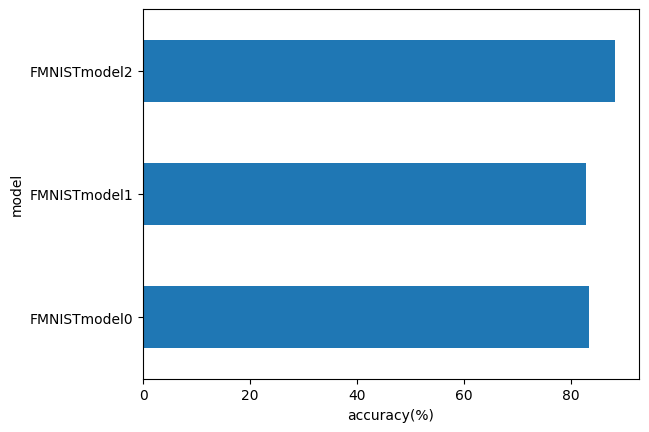

In [41]:
# Visualization
compare_results.set_index("model_name")["accuracy"].plot(kind="barh")
plt.xlabel("accuracy(%)")
plt.ylabel("model")

## 9.Evaluating random predictions with best model


In [42]:
def make_predictions(
    model: torch.nn.Module,
    data: list,
    device: torch.device = device,
):
    pred_probs = []
    model.to(device)
    model.eval()
    with torch.inference_mode():
        for sample in data:
            sample = torch.unsqueeze(sample, dim=0).to(device)
            # forward pass(raw logits)
            pred_logits = model(sample)

            # Turn logits->prediction probabilities
            pred_prob = torch.softmax(pred_logits.squeeze(), dim=0)

            # Copy pred prob to CPU for plotting
            pred_probs.append(pred_prob.cpu())

    # Turning list into tensor with stack
    # print("Pred probs as list:", pred_probs)
    # print("Pred probs as Tensor:", torch.stack(pred_probs))
    return torch.stack(pred_probs)

### Random image picker from test data


In [43]:
import random

random.seed(42)
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data), k=9):
    test_samples.append(sample)
    test_labels.append(label)

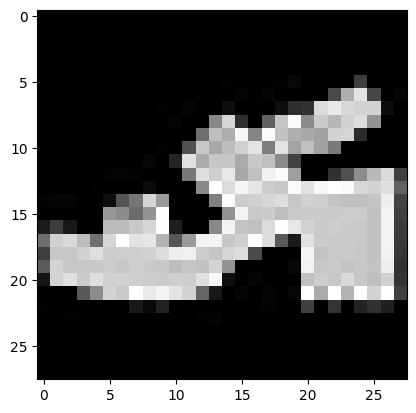

In [44]:
plt.imshow(test_samples[0].squeeze(), cmap="grey")
plt.title = lambda *args, **kwargs: plt.gca().set_title(*args, **kwargs)

In [45]:
# Make predictions
pred_probs = make_predictions(model=model2, data=test_samples, device=device)
# View pred probs
pred_probs[0]

tensor([3.1670e-07, 9.7145e-09, 1.5893e-08, 3.8185e-07, 6.1127e-09, 9.9873e-01,
        1.1371e-06, 6.2904e-05, 7.0717e-06, 1.1965e-03])

In [46]:
# Convert the probs into labels using softmax
pred_classes = pred_probs.argmax(dim=1)
pred_classes

tensor([5, 1, 9, 4, 3, 0, 4, 7, 1])

In [47]:
test_labels

[5, 1, 7, 4, 3, 0, 4, 7, 1]

### 9.2 Visualizing predictions plot


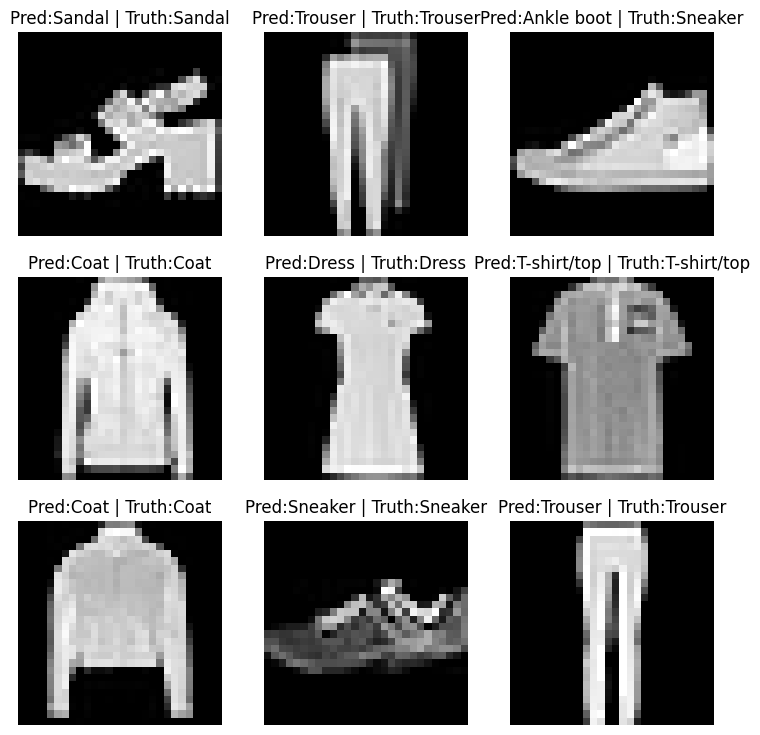

In [48]:
plt.figure(figsize=(9, 9))
row = 3
col = 3
for i, sample in enumerate(test_samples):
    plt.subplot(row, col, i + 1)
    plt.axis(False)
    plt.imshow(sample.permute(1, 2, 0), cmap="gray")
    pred_label = class_names[pred_classes[i]]
    truth_label = class_names[test_labels[i]]
    title_text = f"Pred:{pred_label} | Truth:{truth_label}"
    plt.title(title_text)

## 10.Confusion Matrix


- Making predictions on entire test dataset


In [49]:
# 1 making predictions with trained model

y_preds = []
model2.eval()

with torch.inference_mode():
    for X, y in tqdm(test_dataloader, desc="Making Predictions..."):
        X, y = X.to(device), y.to(device)
        y_logit = model2(X)
        y_pred = torch.softmax(y_logit.squeeze(), dim=0).argmax(dim=1)
        y_preds.append(y_pred.cpu())

y_pred_tensor = torch.cat(y_preds)
y_pred_tensor

Making Predictions...:   0%|          | 0/313 [00:00<?, ?it/s]

tensor([9, 2, 1,  ..., 8, 1, 8])

In [63]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

conf_matrix = ConfusionMatrix(task="multiclass", num_classes=len(class_names))
confmat_tensor = conf_matrix(
    preds=y_pred_tensor,
    target=test_data.targets,
)
confmat_tensor

tensor([[665,   6,  34,  60,   8,   1, 217,   0,   9,   0],
        [ 10, 817,   8, 128,  29,   1,   5,   0,   2,   0],
        [ 10,   3, 797,  12, 106,   0,  66,   0,   6,   0],
        [ 32,  10,  26, 843,  32,   0,  48,   0,   7,   2],
        [  5,   4, 131,  45, 697,   0, 106,   0,  12,   0],
        [  7,   1,   1,  12,   0, 819,   6,  68,  58,  28],
        [ 82,   7, 113,  54,  89,   0, 640,   0,  15,   0],
        [  1,   0,   0,   0,   0,  21,   0, 917,   7,  54],
        [  9,   2,  12,  14,  12,   5,  32,   6, 906,   2],
        [  0,   1,   1,   1,   1,  18,   1,  86,   7, 884]])

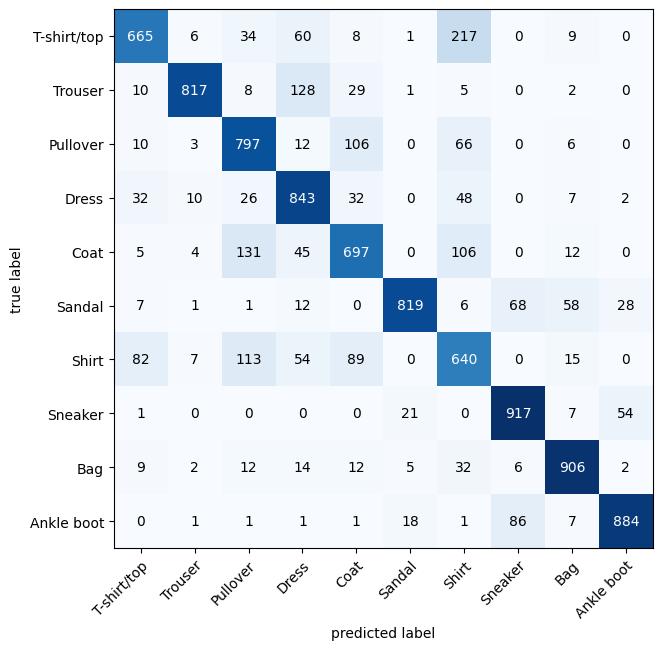

In [64]:
fig, ax = plot_confusion_matrix(
    confmat_tensor.numpy(),
    class_names=class_names,
    figsize=(10, 7),
)